In [1]:
from net.FPN import FPN
import sys
import numpy as np
import random
import math
from eval.eval_by_cropping import eval_model
from Dataset.EvalDatasetConstructor import EvalDatasetConstructor
from metrics import AEBatch, SEBatch
import time
import torch
# obtain the gpu device
assert torch.cuda.is_available()
cuda_device = torch.device("cuda:0")
torch.cuda.set_device(cuda_device)
%matplotlib inline

In [2]:
# config
# config = {
# 'eval_num':182,
# 'mode':'crop',
# 'stage':'numeration',
# 'cuda_device':cuda_device,
# 'gt_map_path_t':"/home/zzn/Documents/Datasets/part_A_final/test_data/gt_map_w_net",
# 'img_path_t':"/home/zzn/Documents/Datasets/part_A_final/test_data/images",
# 'gt_path_t':"/home/zzn/Documents/Datasets/part_A_final/test_data/ground_truth"
# }
# config
config = {
'eval_num':334,
'mode':'crop',
'stage':'numeration',
'cuda_device':cuda_device,
'gt_map_path_t':"/home/zzn/Documents/Datasets/UCF-QNRF_ECCV18/test_data/gt_map_sigma=4_k=7",
'img_path_t':"/home/zzn/Documents/Datasets/UCF-QNRF_ECCV18/test_data/images",
'gt_path_t':"/home/zzn/Documents/Datasets/UCF-QNRF_ECCV18/test_data/ground_truth"
}

In [3]:
# data_load
eval_dataset = EvalDatasetConstructor(
    config['img_path_t'],
    config['gt_map_path_t'],
    config['eval_num'],
    mode=config['mode'],
    stage=config['stage'],
    device=config['cuda_device'])
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [4]:
# model construct
net = FPN().to(config['cuda_device'])
# net = torch.nn.DataParallel(net, device_ids=[5], output_device=cuda_device).to(config['cuda_device'])
net.load_state_dict(torch.load("/home/zzn/PycharmProjects/RESNET_FPN/StateDicts/RESNET_FPN_QNRF.pkl"))
criterion = torch.nn.MSELoss(reduction='sum').to(config['cuda_device'])
ae_batch = AEBatch().to(config['cuda_device'])
se_batch = SEBatch().to(config['cuda_device'])
modules = {
    'model': net,
    'shape': None,
    'ae': ae_batch,
    'se': se_batch,
    'loss': criterion
}

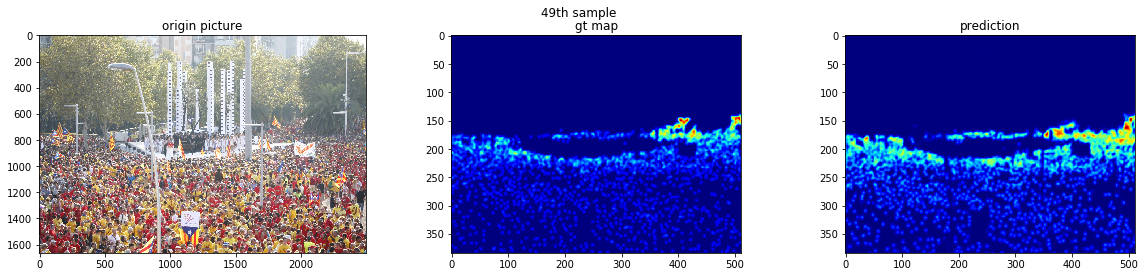

The gt counts of the above sample:2494, and the pred counts:1996.856201171875
MAE = 92.76844024658203, MSE = 167.52008056640625, loss = 12.296146957103364, time cost = 100.2580931186676.


In [5]:
import warnings
warnings.filterwarnings('ignore')
validate_MAE, validate_RMSE, validate_loss, time_cost = eval_model(
    config, eval_loader, modules, True)
sys.stdout.write('MAE = {}, MSE = {}, loss = {}, time cost = {}.\n'.format(
    validate_MAE, validate_RMSE, validate_loss, time_cost))
sys.stdout.flush()

In [9]:
import numpy as np
a = np.array(results)
a = a.T

[[ 290.24539185 1273.47143555  438.43917847  173.90325928  681.74395752
   368.1282959   497.46331787  771.0355835   244.91893005  426.64794922
  1019.56103516  186.09161377  582.55853271  600.10327148  323.70623779
   408.14471436 1137.88977051  154.06929016  198.05914307  455.35324097
   616.26342773  216.68670654  380.02206421  544.80505371  193.90170288
   360.03756714  828.3916626   450.4581604   257.46640015  316.17782593
   250.25469971  965.88415527  431.72479248   89.73715973  452.9364624
   975.48571777  191.42677307  691.35180664  172.46224976  272.48074341
   162.99404907  903.86669922  128.90757751  366.94171143  138.93852234
   375.06411743  372.50299072  406.59832764  479.03479004  933.58538818
   319.09240723  137.93913269  158.74085999  709.82458496  138.63552856
   272.59127808  371.08755493  192.32458496  524.05548096  353.60702515
   179.37390137  276.96914673 1002.75360107  377.59906006  240.45079041
   799.41052246  220.42900085  184.37797546  150.10473633  437.74

In [ ]:
7.1 shang wu yi dian ban
wilson891226
010
魏秀参

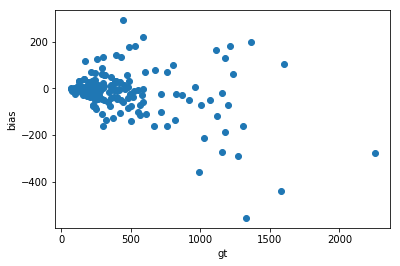

In [12]:
import matplotlib.pyplot as plt
pred_c = a[0]
gt_c = a[1]
plt.scatter(gt_c, pred_c - gt_c)
plt.xlabel('gt')
plt.ylabel('bias')
plt.show()